# Tensor network approximation of Koopman operators: Torus rotation

In [1]:
%load_ext nb_mypy
%nb_mypy Off
    
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax
import jax.numpy as jnp
import jaxopt as opt
import matplotlib as mpl
import matplotlib.pyplot as plt
import nlsa.function_algebra2 as fun
import nlsa.jax.fourier_t2 as t2
import nlsa.jax.vector_algebra as vec
import os
import time
from functools import partial
from ipywidgets import interact, fixed, IntSlider
from jax import Array, jit, vmap
from jax.scipy.linalg import toeplitz
from jax.scipy.special import i0
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import compose_by, exponentiate_by, gelfand, \
    make_linear_map, make_qeval, multiply_by, normalize, precompose_by, \
    FromScalarField
from nlsa.dynamics import orbit, semigroup
from nlsa.function_algebra2 import compose, eval_at, FunctionSpace
from nlsa.jax.dynamics import make_rotation_generator_fourier, \
    make_rotation_vector_field
from nlsa.jax.matrix_algebra import MatrixAlgebra, MatrixSpace
from nlsa.jax.vector_algebra import MeasureFnAlgebra, VectorAlgebra
from nlsa.jax.special import iv0_ratio
from nlsa.operator_algebra import OperatorAlgebra
from pathlib import Path
from scipy.sparse.linalg import LinearOperator, eigs
from typing import Callable, Literal, Optional, TypeVar

In [3]:
IDX_CPU: int = 0
IDX_GPU: Optional[int] = 1
XLA_MEM_FRACTION: Optional[float] = '.9'
F64: bool = True
MINV = True
SORT_BY: Literal['energy', 'frequency'] = 'energy'
FREE_MEM: bool = False
SAVE_FIGS: bool = True

if IDX_GPU is not None and XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

device_cpu = jax.devices("cpu")[IDX_CPU]

if IDX_GPU is not None:
    device_gpu = jax.devices("gpu")[IDX_GPU]
    jax.config.update("jax_default_device", device_gpu)
else:
    jax.config.update("jax_default_device", device_cpu)
            
if F64:
    jax.config.update("jax_enable_x64", True)
    r_dtype = jnp.float64
    c_dtype = jnp.complex128
else:
    r_dtype = jnp.float32
    c_dtype = jnp.complex64

import netket

In [4]:
chunk_size = 8

jvmap = compose(jit, vmap)
vvmap = compose(vmap, vmap)
jvvmap = compose(jit, vvmap)
apply_chunked = partial(netket.jax.apply_chunked, chunk_size=chunk_size)
cmap = compose(apply_chunked, jvmap)


def ccmap(f: Callable[[Array], Array]) -> Callable[[Array], Array]:
    cf = cmap(f)
    
    def ccf(xs):
        xs_ = xs.reshape(-1, xs.shape[-1])
        ys_ = cf(xs_)
        return ys_.reshape(xs.shape[:-1])

    return ccf

In [5]:
R = r_dtype
C = c_dtype
S1 = Array
S1s = Array
T2 = Array
T2s = Array
L2_Z = Array
L2_Z2 = Array
Z = int
X = TypeVar('X')
Y = TypeVar('Y')
F = Callable[[X], Y]

## True dynamics

In [6]:
def make_torus_rotation(alphas: tuple[float, float]) -> F[T2, T2]:
    """Make torus rotation map by angles alphas."""
    twopi = 2.0 * jnp.pi
    a = jnp.asarray(alphas, dtype=r_dtype)
    def phi(x: T2) -> T2:
        y = (x + a) % twopi
        return y
    return phi


def make_von_mises_density(kappa: float, mu: float) -> F[S1, R]:
    """Make Von Mises probability density function on the circle."""
    def f(x: S1) -> R:
        y = jnp.exp(kappa * jnp.cos(x - mu)) / i0(kappa)
        return y        
    return f


def make_torus_von_mises_density(kappas: tuple[float, float],
                                 mus: tuple[float, float]) -> F[T2, R]:
    """Make Von Mises probability density function on the torus."""
    f0 = make_von_mises_density(kappas[0], mus[0])
    f1 = make_von_mises_density(kappas[1], mus[1])
    
    def f(x: T2) -> R:
        return f0(x[0]) * f1(x[1])
    
    return f

In [7]:
alphas = (1.0, jnp.sqrt(30.0))
dt = 0.1
mus = (jnp.pi, jnp.pi)
kappas = (1.0, 6.0)
n_steps = 64

In [8]:
v = make_rotation_vector_field(jnp.array(alphas))
phi = make_torus_rotation(tuple(alpha * dt for alpha in alphas))
u = compose_by(fun, phi)
f = make_torus_von_mises_density(kappas, mus)
f_orb = map(jvvmap, orbit(f, u))
fs = take(n_steps + 1, f_orb) 

In [43]:
n_thetas = 512

thetas: S1s = jnp.linspace(0.0, 2.0*jnp.pi, n_thetas, endpoint=False, dtype=r_dtype)
x1s, x2s = jnp.meshgrid(thetas, thetas)
xs: T2s = jnp.concatenate((x1s[:, :, jnp.newaxis], x2s[:, :, jnp.newaxis]), 
                           axis=2)
x1s = x1s / jnp.pi
x2s = x2s / jnp.pi

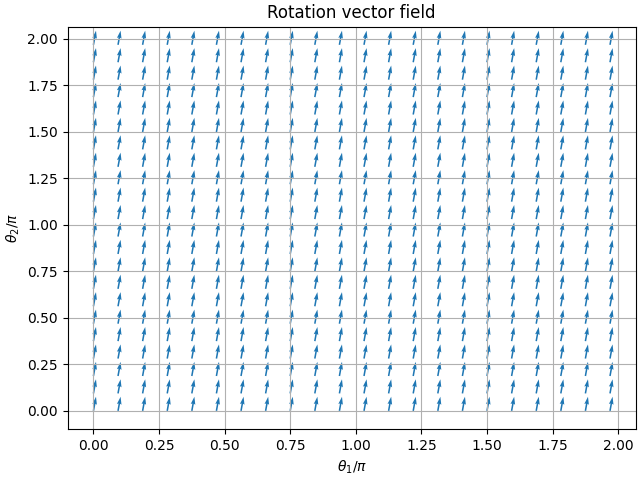

In [10]:
n_skip = 12
i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_vec(i):
    fig, ax = plt.subplots(num=i_fig, constrained_layout=True)
    return fig, ax


def plotfig_vec(figspecs, save_fig=False):
    x1s_plt = x1s[::n_skip, ::n_skip]
    x2s_plt = x2s[::n_skip, ::n_skip]
    vs_plt = jvvmap(v)(xs[::n_skip, ::n_skip, :])
    fig, ax = figspecs    
    #ax.scatter(x1s_plt, x2s_plt, s=8)
    cmap = plt.get_cmap('tab10')
    ax.quiver(x1s_plt, x2s_plt, vs_plt[:, :, 0], vs_plt[:, :, 1],
              color=cmap(0))
    ax.grid()
    ax.set_xlabel(r'$\theta_1/\pi$')
    ax.set_ylabel(r'$\theta_2/\pi$')
    ax.set_title('Rotation vector field')

    if save_fig:
        fnames = ['vec',
                  f'alpha{alphas[1]:.2f}']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / 'torus_rotation' / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, dpi=600)


plotfig_vec(initfig_vec(i_fig), SAVE_FIGS)

interactive(children=(IntSlider(value=10, continuous_update=False, description='j', max=64), Output()), _dom_c…

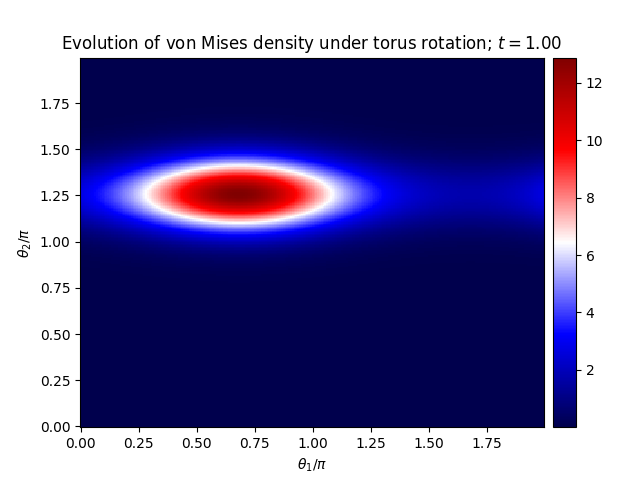

In [11]:
i_fig = 2

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_true(i):
    fig, ax = plt.subplots(num=i)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    return fig, ax, cax


slider_true = IntSlider(value=10, min=0, max=n_steps, continuous_update=False)


@interact(j=slider_true, figspecs=fixed(initfig_true(i_fig))) 
def plotfig_true(j, figspecs):
    fig, ax, cax = figspecs
    t = j * dt
    f = fs[j]
    fxs = f(xs)
    a = jnp.max(fxs)
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1s, x2s, fxs, cmap="seismic")
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Evolution of von Mises density under torus rotation; "
                 f"$t = {t:.2f}$")

## Eigendecomposition of the generator

In [12]:
def make_rkha_lambda_s1(p: float, tau: float) -> F[Z, R]:
    """Make inverse subexponential weight function on the dual group of S1."""
    def lamb(k: int) -> R:
        return jnp.exp(-tau * jnp.abs(r_dtype(k))**p)
    return lamb


def unit_fourier_s1(k_max: int) -> L2_Z:
    """Compute Fourier representation of unit function on S1."""
    n = 2*k_max + 1
    u = jnp.zeros(n, dtype=r_dtype)
    u = u.at[k_max].set(1.0)
    return u


def unit_fourier_t2(k_max: int) -> L2_Z2:
    """Compute Fourier representation of unit function on T2."""
    u1 = unit_fourier_s1(k_max)
    return jnp.kron(u1, u1)

In [13]:
max_wavenum = 64
rkha_p = 0.75
rkha_tau = 0.001

wavenums = jnp.arange(-max_wavenum, max_wavenum + 1)
vec_f = VectorAlgebra(dim=(2*max_wavenum + 1)**2, dtype=c_dtype)
op_f = OperatorAlgebra(hilb=vec_f)
sqrt_lambfun_s1 = make_rkha_lambda_s1(rkha_p, 0.5*rkha_tau)
sqrt_lambs_s1 = vmap(sqrt_lambfun_s1)(wavenums)
sqrt_lambs = jnp.kron(sqrt_lambs_s1, sqrt_lambs_s1)
inv_sqrt_lambs = 1.0 / sqrt_lambs
lambs = sqrt_lambs**2
sqrt_kernel_op_fourier = multiply_by(vec_f, sqrt_lambs)
fourier_basis = t2.make_fourier_basis((wavenums, wavenums))
fourier_synth = vec.make_fn_synthesis_operator(fourier_basis)
rkha_synth = compose(fourier_synth, sqrt_kernel_op_fourier)

In [14]:
res_z = 0.1

vectorfield_fourier = make_rotation_generator_fourier(alphas, (max_wavenum, 
                                                               max_wavenum),
                                                      hermitian=True)
gev_a_op = op_f.mul(sqrt_kernel_op_fourier,
                    op_f.mul(vectorfield_fourier,
                    sqrt_kernel_op_fourier))
gev_b_op = op_f.add(op_f.smul(res_z**2, op_f.unit()),
                    op_f.mul(vectorfield_fourier, vectorfield_fourier))
matvec_a = jit(gev_a_op)
matmat_a = jit(vmap(gev_a_op, in_axes=1, out_axes=1))
matvec_b = jit(gev_b_op)
matmat_b = jit(vmap(gev_b_op, in_axes=1, out_axes=1))
gev_a_lop = LinearOperator(shape=(vec_f.dim, vec_f.dim), dtype=r_dtype,
                           matvec=matvec_a, matmat=matmat_a,
                           rmatvec=matvec_a, rmatmat=matmat_a)
gev_b_lop = LinearOperator(shape=(vec_f.dim, vec_f.dim), dtype=r_dtype,
                           matvec=matvec_b, matmat=matmat_b,
                           rmatvec=matvec_b, rmatmat=matmat_b)

if MINV:
    gev_binv_op = partial(opt.linear_solve.solve_lu, gev_b_op)
    matvec_binv = jit(gev_binv_op)
    matmat_binv = jit(vmap(gev_binv_op, in_axes=1, out_axes=1))
    gev_binv_lop = LinearOperator(shape=(vec_f.dim, vec_f.dim), dtype=r_dtype,
                                  matvec=matvec_binv, matmat=matmat_binv,
                                  rmatvec=matvec_binv, rmatmat=matmat_binv)

In [15]:
n_eigs = 1024

start_time = time.perf_counter()

if MINV:
    unsorted_evals, unsorted_evecs = eigs(gev_a_lop, k=n_eigs, which='LM',
                                      M=gev_b_lop, Minv=gev_binv_lop)
else:
    unsorted_evals, unsorted_evecs = eigs(gev_a_lop, k=n_eigs, which='LM',
                                          M=gev_b_lop)
end_time = time.perf_counter()
print(f'Resolvent eigendecomposition took {end_time - start_time:.3e} s')

Resolvent eigendecomposition took 9.170e+02 s


In [16]:
normalize_vec_f = jit(vmap(partial(normalize, vec_f), in_axes=1, out_axes=1))
unsorted_evecs= normalize_vec_f(unsorted_evecs)
unsorted_engys = jnp.sum(jnp.abs(unsorted_evecs)**2 / lambs[:, jnp.newaxis],
                         axis=0) - 1.0

match SORT_BY:
    case 'frequency':
        isort = jnp.argsort(jnp.abs(unsorted_evals.real))[::-1]
    case 'energy':
        isort = jnp.argsort(unsorted_engys)

res_evals = unsorted_evals[isort].real
eigenfreqs = (1.0 + jnp.sqrt(1.0 - 4.0 * res_z**2 * res_evals**2)) \
    / (2.0 * res_evals)
eigenfreqs = jnp.concatenate((jnp.array([0.0]), eigenfreqs), axis=None)
unit_fourier = unit_fourier_t2(max_wavenum)[:, jnp.newaxis]
eigenfuncs_fourier = jnp.concatenate((unit_fourier, unsorted_evecs[:, isort]),
                                     axis=1)
engys = jnp.concatenate((jnp.array([0.0]), unsorted_engys[isort]), axis=None)

print('First 10 compactified resolvent eigenvalues:')
print(res_evals[0:10])
print('Corresponding eigenfrequencies:')
print(eigenfreqs[1:11])
print('Corresponding Dirichlet energies:')
print(engys[1:11])

First 10 compactified resolvent eigenvalues:
[-0.98910941  0.98910941 -0.18233092  0.18233092 -0.49791502  0.49791502
 -0.0911261   0.0911261  -0.1540419  -0.22279519]
Corresponding eigenfrequencies:
[ -1.0010207    1.0010207   -5.4827094    5.4827094   -2.00338328
   2.00338328 -10.97289325  10.97289325  -6.49019937  -4.48619813]
Corresponding Dirichlet energies:
[0.0010005  0.0010005  0.0010005  0.0010005  0.00168321 0.00168321
 0.00168321 0.00168321 0.002002   0.002002  ]


In [17]:
if FREE_MEM:
    del unsorted_evecs

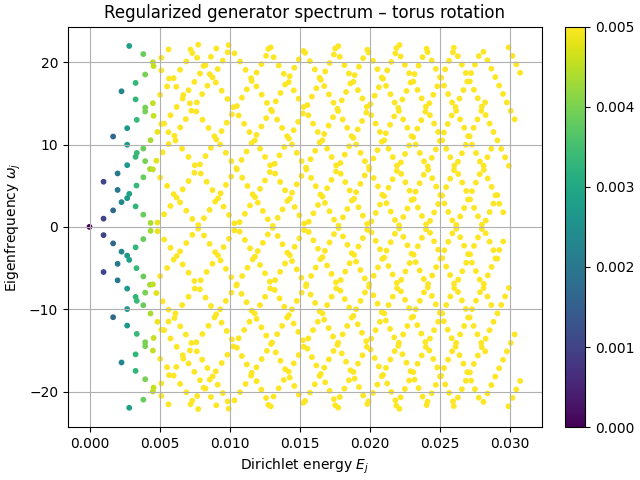

In [18]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

    
def initfig_spec(i):
    fig, ax = plt.subplots(num=i_fig, constrained_layout=True)
    return fig, ax


def plotfig_spec(figspecs, save_fig=False):
    fig, ax = figspecs
    im = ax.scatter(engys, eigenfreqs, s=10, c=engys,
                    vmin=0.0, vmax=0.005)
    cb = fig.colorbar(im, ax=ax)
    ax.grid(True)
    ax.set_xlabel("Dirichlet energy $E_j$")
    ax.set_ylabel(r"Eigenfrequency $\omega_j$")
    ax.set_title("Regularized generator spectrum \u2013 torus rotation")

    if save_fig:
        fnames = ['spec',
                  f'alpha{alphas[1]:.2f}',
                  f'kmax{max_wavenum}',
                  f'p{rkha_p:.2f}',
                  f'tau{rkha_tau:.4f}',
                  f'z{res_z:.2f}',
                  f'neigs{n_eigs}']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / 'torus_rotation' / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, dpi=600)


plotfig_spec(initfig_spec(i_fig), SAVE_FIGS)

interactive(children=(IntSlider(value=38, continuous_update=False, description='j', max=1023), Output()), _dom…

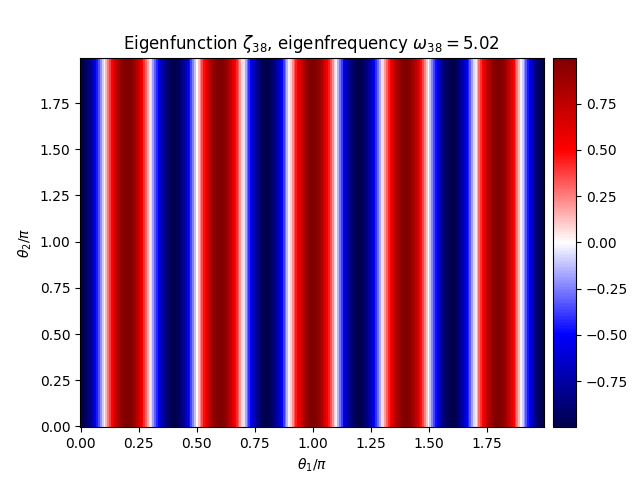

In [19]:
i_fig = 4

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

    
def initfig_eigs(i):
    fig, ax = plt.subplots(num=i_fig)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    return fig, ax, cax

    
slider_eigs = IntSlider(value=38, min=0, max=n_eigs-1,
                        continuous_update=False)


@interact(j=slider_eigs, figspecs=fixed(initfig_eigs(i_fig))) 
def plotfig_eigs(j, figspecs):
    fig, ax, cax = figspecs
    zeta = jvvmap(rkha_synth(eigenfuncs_fourier[:, j]))
    zetaxs = zeta(xs).real
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1s, x2s, zetaxs,
                       norm=mpl.colors.CenteredNorm(), cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Eigenfunction $\zeta_{{{j}}}$, "
                 f"eigenfrequency $\omega_{{{j}}} = {eigenfreqs[j]:.2f}$")

## Classical Koopman approximation

In [20]:
def von_mises_fourier(k_max: int, kappa: float, mu: float) -> L2_Z:
    """Compute Fourier coefficients of the von Mises density."""
    ks = jnp.arange(-k_max, k_max + 1, dtype=r_dtype)
    return iv0_ratio(jnp.abs(ks), kappa) * jnp.exp(-1j * ks * mu)


def torus_von_mises_fourier(k_max: int, kappas: tuple[float, float],
                            mus: tuple[float, float]) -> L2_Z2:
    """Compute Fourier coefficients of the von Mises density on the torus."""
    f0 = von_mises_fourier(k_max, kappas[0], mus[0])
    f1 = von_mises_fourier(k_max, kappas[1], mus[1])
    return jnp.kron(f0, f1)

In [21]:
n_koopmaneigs = 128

vec_k = VectorAlgebra(dim=(2*n_koopmaneigs + 1), dtype=c_dtype)
mat_k = MatrixAlgebra(hilb=vec_k, dtype=c_dtype)
mat_f = MatrixAlgebra(hilb=vec_f, dtype=c_dtype)
mat_fk = MatrixSpace(hilb_in=vec_f, hilb_out=vec_k, dtype=c_dtype)
mat_kf = MatrixSpace(hilb_in=vec_k, hilb_out=vec_f, dtype=c_dtype) 

to_fourier_basis_mat = eigenfuncs_fourier[:, 0 : vec_k.dim]
to_koopman_eigenbasis_mat = mat_kf.star(to_fourier_basis_mat)
to_fourier_basis = make_linear_map(mat_kf, to_fourier_basis_mat)
to_koopman_eigenbasis = make_linear_map(mat_fk, to_koopman_eigenbasis_mat)

In [22]:
f_k = jit(to_koopman_eigenbasis)(torus_von_mises_fourier(max_wavenum, kappas,
                                                         mus) / sqrt_lambs)

In [23]:
u_k = multiply_by(vec_k, jnp.exp(1j * eigenfreqs[0 : vec_k.dim] * dt))
f_k_orb = orbit(f_k, u_k)
f_cl_orb=map(jvvmap,
             map(compose(rkha_synth, to_fourier_basis), f_k_orb))
f_cls = take(n_steps + 1, f_cl_orb)

interactive(children=(IntSlider(value=10, continuous_update=False, description='j', max=64), Output()), _dom_c…

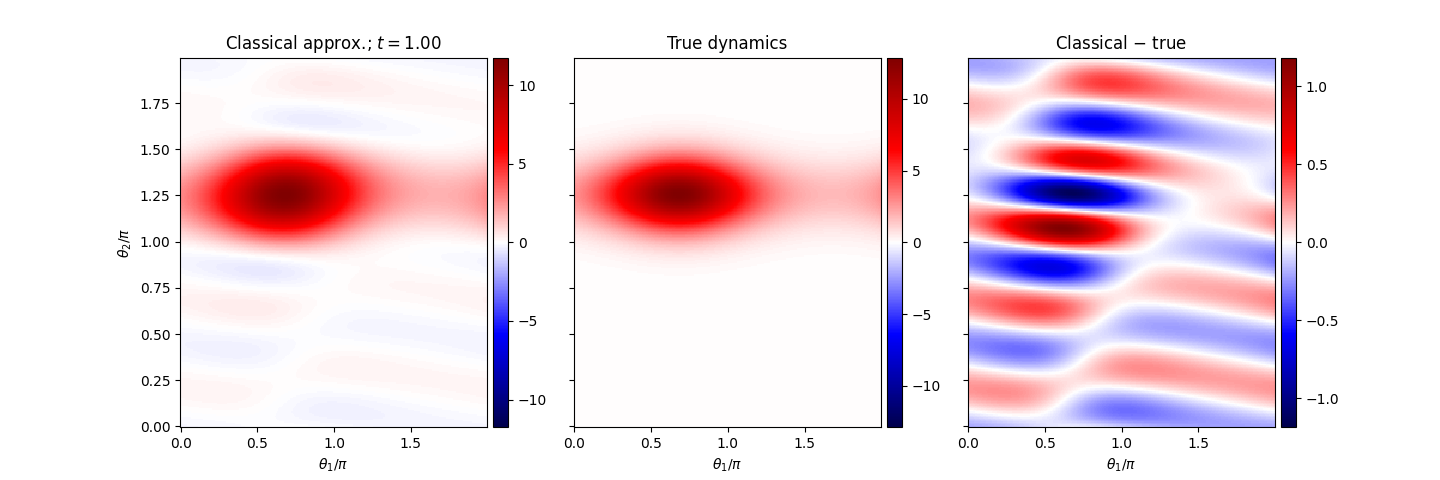

In [24]:
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

    
def initfig_cl(i): 
    fig = plt.figure(num=i_fig, figsize=plt.figaspect(1. / 3.))
    axs = [fig.add_subplot(1, 3, i + 1) for i in range(3)]
    ax_dividers = [make_axes_locatable(ax) for ax in axs]
    caxs = [ax_divider.append_axes("right", size="5%", pad="2%")
            for ax_divider in ax_dividers]
    return fig, axs, caxs


slider_cl = IntSlider(value=10, min=0, max=n_steps, continuous_update=False)


@interact(j=slider_cl, figspecs=fixed(initfig_cl(i_fig))) 
def plotfunc_cl(j, figspecs):
    fig, axs, caxs = figspecs
    t = j * dt
    fxs = f_cls[j](xs).real
    gxs = fs[j](xs)
    exs = fxs - gxs 
    a = jnp.max(fxs)
    at = jnp.max(gxs)
    ae = jnp.max(jnp.abs(exs))
    [ax.cla() for ax in axs]
    [cax.cla() for cax in caxs]

    ax, cax = axs[0], caxs[0]
    im = ax.pcolormesh(x1s, x2s, fxs, cmap="seismic", vmin=-a, vmax=a)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel(r'$\theta_1/\pi$')
    ax.set_ylabel(r'$\theta_2/\pi$')
    ax.set_title(f"Classical approx.; $t = {t:.2f}$")

    ax, cax = axs[1], caxs[1]
    im = ax.pcolormesh(x1s, x2s, gxs, cmap="seismic", vmin=-at, vmax=at)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel(r'$\theta_1/\pi$')
    ax.set_yticklabels([])
    ax.set_title("True dynamics")

    ax, cax = axs[2], caxs[2]
    im = ax.pcolormesh(x1s, x2s, exs, cmap="seismic", vmin=-ae, vmax=ae)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel(r'$\theta_1/\pi$')
    ax.set_yticklabels([])
    ax.set_title("Classical $-$ true")

## Quantum mechanical approximation

In [25]:
def von_mises_fourier(k_max: int, kappa: float, mu: float) -> L2_Z:
    """Compute Fourier coefficients of the von Mises density."""
    ks = jnp.arange(-k_max, k_max + 1, dtype=r_dtype)
    return iv0_ratio(jnp.abs(ks), kappa) * jnp.exp(-1j * ks * mu)


def torus_von_mises_fourier(k_max: int, kappas: tuple[float, float],
                            mus: tuple[float, float]) -> L2_Z2:
    """Compute Fourier coefficients of the von Mises density on the torus."""
    f0 = von_mises_fourier(k_max, kappas[0], mus[0])
    f1 = von_mises_fourier(k_max, kappas[1], mus[1])
    return jnp.kron(f0, f1)
    
    
def make_von_mises_feature_map(kappa: float, k_max: int) -> F[S1, L2_Z]:
    """Make von Mises feature map on circle."""
    return partial(von_mises_fourier, k_max, kappa)


def make_torus_von_mises_feature_map(kappa: float, k_max: int) -> F[T2, L2_Z2]:
    """Make von Mises feature map on torus."""
    feat1 = make_von_mises_feature_map(kappa, k_max)
    
    def feat2(x: T2) -> L2_Z2:
        return jnp.kron(feat1(x[0]), feat1(x[1]))
    
    return feat2

In [26]:
n_thetas_l2 = 4 * max_wavenum

thetas_l2: S1s = jnp.linspace(0.0, 2.0*jnp.pi, n_thetas_l2, endpoint=False,
                             dtype=r_dtype)
x1s_l2, x2s_l2 = jnp.meshgrid(thetas_l2, thetas_l2)
xs_l2: T2s = jnp.concatenate((x1s_l2[:, :, jnp.newaxis], x2s_l2[:, :, jnp.newaxis]), 
                              axis=2).reshape(n_thetas_l2**2, 2)
meas = vec.make_normalized_counting_measure(n_thetas_l2**2)
l2_t2 = MeasureFnAlgebra(dim=n_thetas_l2**2,
                         dtype=c_dtype,
                         inclusion_map=vec.veval_at(xs_l2),
                         weight=1.0/r_dtype(n_thetas_l2**2),
                         measure=meas)
op_l2_t2 = OperatorAlgebra(hilb=l2_t2)
to_l2_t2 = compose(l2_t2.incl,
                   compose(rkha_synth, 
                           to_fourier_basis))
f_op = multiply_by(l2_t2, l2_t2.incl(f))

In [27]:
kappa_eval = 500.0

feat = make_torus_von_mises_feature_map(kappa_eval, max_wavenum)
qm_feat = compose(partial(normalize, vec_k),
                  compose(to_koopman_eigenbasis, 
                          compose(multiply_by(vec_f, inv_sqrt_lambs),
                                  feat)))
p_k = multiply_by(vec_k, jnp.exp(-1j * eigenfreqs[0 : vec_k.dim] * dt))
p_semi = semigroup(p_k)
p_l2 = map(precompose_by(fun, to_l2_t2), p_semi)
qm_feat_l2_orb = map(compose_by(fun, qm_feat), p_l2)
qm_eval_l2_orb = map(partial(make_qeval, op_l2_t2), qm_feat_l2_orb)
f_qm_orb = map(ccmap,
               map(precompose_by(fun, gelfand(op_l2_t2, f_op)),
                   qm_eval_l2_orb))
f_qms = take(n_steps + 1, f_qm_orb)

interactive(children=(IntSlider(value=10, continuous_update=False, description='j', max=64), Output()), _dom_c…

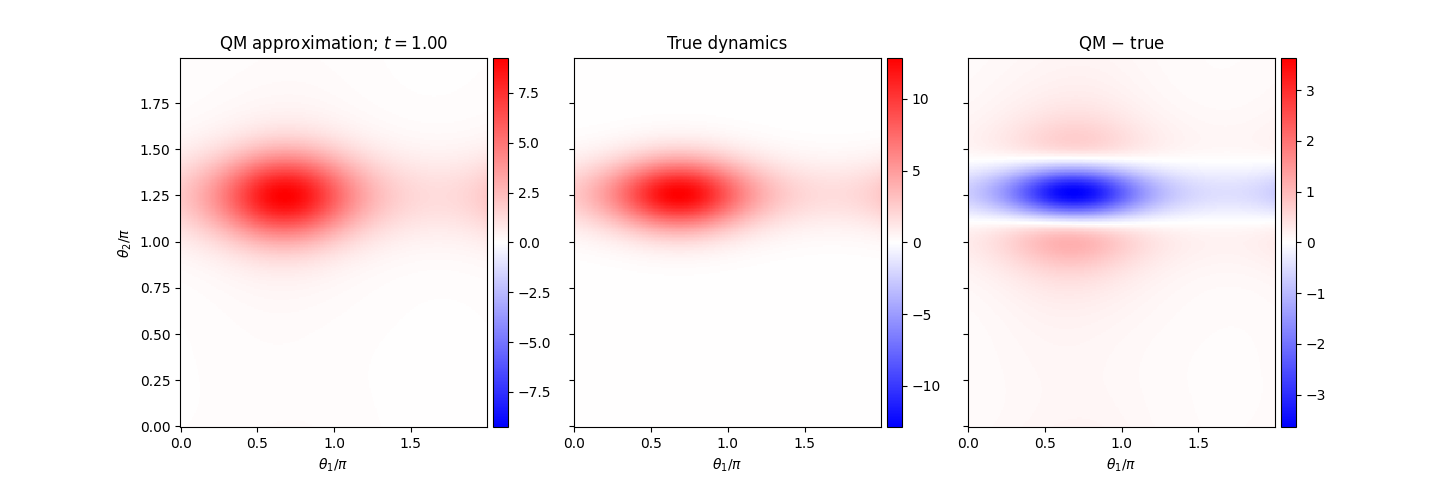

In [34]:
i_fig = 6

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

    
def initfig_qm(i): 
    fig = plt.figure(num=i_fig, figsize=plt.figaspect(1. / 3.))
    axs = [fig.add_subplot(1, 3, i + 1) for i in range(3)]
    ax_dividers = [make_axes_locatable(ax) for ax in axs]
    caxs = [ax_divider.append_axes("right", size="5%", pad="2%")
            for ax_divider in ax_dividers]
    return fig, axs, caxs


slider_qm = IntSlider(value=10, min=0, max=n_steps, continuous_update=False)


@interact(j=slider_qm, figspecs=fixed(initfig_qm(i_fig))) 
def plotfunc_qm(j, figspecs):
    fig, axs, caxs = figspecs
    t = j * dt
    fxs = f_qms[j](xs).real
    gxs = fs[j](xs)
    exs = fxs - gxs 
    a = jnp.max(fxs)
    at = jnp.max(gxs)
    ae = jnp.max(jnp.abs(exs))
    [ax.cla() for ax in axs]
    [cax.cla() for cax in caxs]

    ax, cax = axs[0], caxs[0]
    im = ax.pcolormesh(x1s, x2s, fxs, cmap="bwr", vmin=-a, vmax=a)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"QM approximation; $t = {t:.2f}$")

    ax, cax = axs[1], caxs[1]
    im = ax.pcolormesh(x1s, x2s, gxs, cmap="bwr", vmin=-at, vmax=at)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_yticklabels([])
    ax.set_title("True dynamics")

    ax, cax = axs[2], caxs[2]
    im = ax.pcolormesh(x1s, x2s, exs, cmap="bwr", vmin=-ae, vmax=ae)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_yticklabels([])
    ax.set_title("QM $-$ true")

## Fock space approximation

In [35]:
n_koopmaneigs_fock = n_koopmaneigs

fun_t2 = FunctionSpace(codomain=FromScalarField(l2_t2.scl))
vec_k_fock = VectorAlgebra(dim=(2*n_koopmaneigs_fock + 1), dtype=c_dtype)
mat_k_fock = MatrixAlgebra(hilb=vec_k_fock, dtype=c_dtype)
mat_fk_fock = MatrixSpace(hilb_in=vec_f, hilb_out=vec_k_fock, dtype=c_dtype)
mat_kf_fock = MatrixSpace(hilb_in=vec_k_fock, hilb_out=vec_f, dtype=c_dtype) 

to_fourier_basis_mat_fock = eigenfuncs_fourier[:, 0 : vec_k_fock.dim]
to_koopman_eigenbasis_mat_fock = mat_kf_fock.star(to_fourier_basis_mat_fock)
to_fourier_basis_fock = make_linear_map(mat_kf_fock, to_fourier_basis_mat_fock)
to_koopman_eigenbasis_fock = make_linear_map(mat_fk_fock, 
                                             to_koopman_eigenbasis_mat_fock)
to_rkha_fock = compose(rkha_synth, to_fourier_basis_fock)
to_l2_t2_fock = compose(l2_t2.incl, to_rkha_fock)

In [36]:
kappa_eval_fock = 500.0
n_root = 10

feat_fock = make_torus_von_mises_feature_map(kappa_eval_fock / r_dtype(n_root),
                                             max_wavenum)
qm_feat_fock = compose(partial(normalize, vec_k_fock),
                       compose(to_koopman_eigenbasis_fock, 
                               compose(multiply_by(l2_t2, inv_sqrt_lambs),
                                       feat_fock)))
p_k_fock = multiply_by(vec_k_fock, 
                       jnp.exp(-1j * eigenfreqs[0 : vec_k_fock.dim] * dt))
p_semi_fock = semigroup(p_k_fock)
exponentiate_to_l2 = compose(l2_t2.incl,
                             compose(exponentiate_by(fun_t2, n_root),
                                     to_rkha_fock))
p_l2_fock = map(precompose_by(fun, exponentiate_to_l2), p_semi_fock)
qm_feat_l2_fock_orb = map(compose_by(fun, qm_feat_fock), p_l2_fock)
qm_eval_l2_fock_orb = map(partial(make_qeval, op_l2_t2), qm_feat_l2_fock_orb)
qm_evals_l2_fock = take(n_steps + 1, qm_eval_l2_fock_orb)
f_fock_unnormalized = map(precompose_by(fun, gelfand(op_l2_t2, f_op)),
                          qm_evals_l2_fock)
u_fock = map(precompose_by(fun, gelfand(op_l2_t2, op_l2_t2.unit())),
                           qm_evals_l2_fock)
f_fock_normalized = map(fun_t2.div, f_fock_unnormalized, u_fock)
f_focks = list(map(ccmap, f_fock_normalized))

interactive(children=(IntSlider(value=10, continuous_update=False, description='j', max=64), Output()), _dom_c…

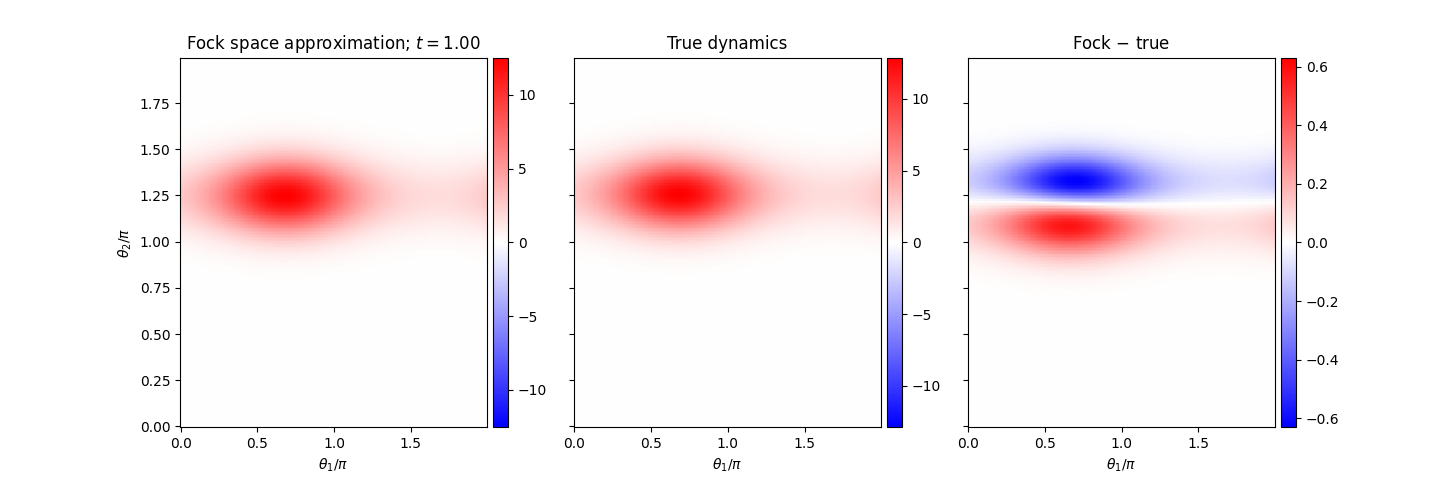

In [37]:
i_fig = 7

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

    
def initfig_fock(i):
    fig = plt.figure(num=i_fig, figsize=plt.figaspect(1. / 3.))
    axs = [fig.add_subplot(1, 3, i + 1) for i in range(3)]
    ax_dividers = [make_axes_locatable(ax) for ax in axs]
    caxs = [ax_divider.append_axes("right", size="5%", pad="2%")
            for ax_divider in ax_dividers]
    return fig, axs, caxs


slider_fock = IntSlider(value=10, min=0, max=n_steps, continuous_update=False)


@interact(j=slider_fock, figspecs=fixed(initfig_fock(i_fig))) 
def plotfunc_fock(j, figspecs):
    fig, axs, caxs = figspecs
    t = j * dt
    fxs = f_focks[j](xs).real
    gxs = fs[j](xs)
    exs = fxs - gxs 
    a = jnp.max(fxs)
    at = jnp.max(gxs)
    ae = jnp.max(jnp.abs(exs))
    [ax.cla() for ax in axs]
    [cax.cla() for cax in caxs]

    ax, cax = axs[0], caxs[0]
    im = ax.pcolormesh(x1s, x2s, fxs, cmap="bwr", vmin=-a, vmax=a)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Fock space approximation; $t = {t:.2f}$")
    
    ax, cax = axs[1], caxs[1]
    im = ax.pcolormesh(x1s, x2s, gxs, cmap="bwr", vmin=-at, vmax=at)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_yticklabels([])
    ax.set_title(f"True dynamics")

    ax, cax = axs[2], caxs[2]
    im = ax.pcolormesh(x1s, x2s, exs, cmap="bwr", vmin=-ae, vmax=ae)
    cb = fig.colorbar(im, cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_yticklabels([])
    ax.set_title(f"Fock $-$ true")

## Summary results

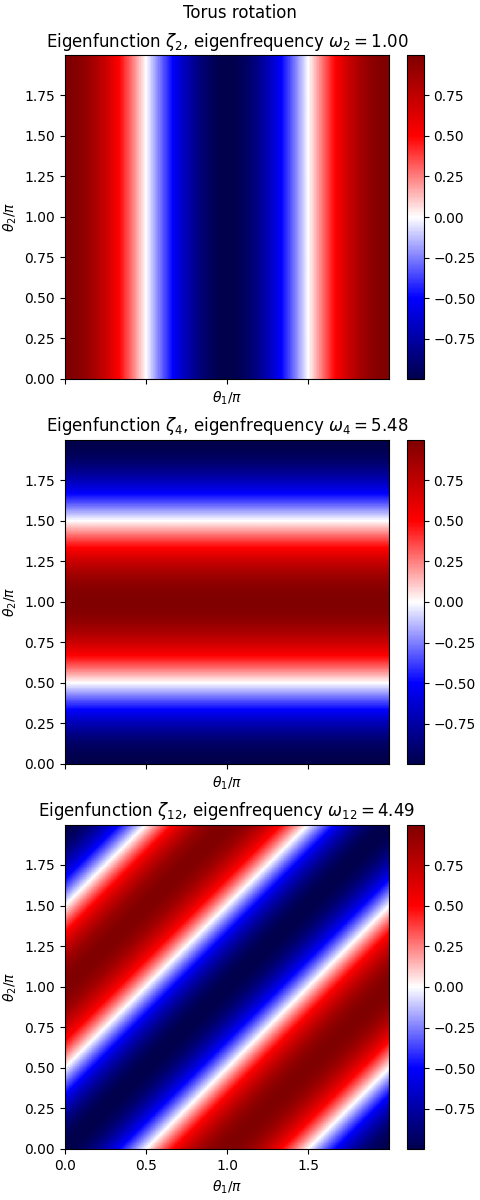

In [44]:
i_fig = 8

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

j_eigs = [2, 4, 12]


def initfig_eigs_tiled(i):
    fig, axs = plt.subplots(len(j_eigs), 1, 
                            figsize=(0.8*6, 0.8*15),
                            subplot_kw=dict(box_aspect=1.0), 
                            num=i_fig, 
                            sharex=True,
                            constrained_layout=True)
    return fig, axs


def plotfig_eigs_tiled(figspecs, save_fig=False):
    fig, axs = figspecs
    fig.suptitle('Torus rotation')

    for (j, ax) in zip(j_eigs, axs):
            zeta = jvvmap(rkha_synth(eigenfuncs_fourier[:, j]))
            zetaxs = zeta(xs).real
            im = ax.pcolormesh(x1s, x2s, zetaxs,
                               norm=mpl.colors.CenteredNorm(), cmap="seismic")
            cb = fig.colorbar(im, ax=ax)
            ax.set_xlabel(r'$\theta_1/\pi$')
            ax.set_ylabel(r'$\theta_2/\pi$')
            ax.set_title(f"Eigenfunction $\zeta_{{{j}}}$, "
                         f"eigenfrequency $\omega_{{{j}}} = {eigenfreqs[j]:.2f}$")

    if save_fig:
        fnames = ['eigs',
                  f'alpha{alphas[1]:.2f}',
                  f'kmax{max_wavenum}',
                  f'p{rkha_p:.2f}',
                  f'tau{rkha_tau:.4f}',
                  f'z{res_z:.2f}',
                  f'neigs{n_eigs}']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / 'torus_rotation' / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, dpi=600)


plotfig_eigs_tiled(initfig_eigs_tiled(i_fig), SAVE_FIGS)

In [ ]:
i_figs = (9, 10)

for i_fig in i_figs:
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)

j_steps = [0, 10, 20, 40]


def initfigs_evo_tiled(ifigs):
    figsize = (0.75*6.5*11.0/4.0, 0.9*12.0)
    figf, axfs = plt.subplots(4, len(j_steps),
                             figsize=figsize,
                             subplot_kw=dict(box_aspect=1.0), 
                             num=ifigs[0], 
                             sharex=True,
                             sharey=True,
                             constrained_layout=True,
                             clear=True)
    fige, axes = plt.subplots(4, len(j_steps),
                              figsize=figsize,
                              subplot_kw=dict(box_aspect=1.0), 
                              num=ifigs[1], 
                              sharex=True,
                              sharey=True,
                              constrained_layout=True,
                              clear=True)
    return (figf, fige), (axfs, axes)


def plotfigs_evo_tiled(figspecs, save_fig=False):
    (figf, fige), (axfss, axess) = figspecs
    
    for (j, axfs, axes) in zip(j_steps, axfss.T, axess.T):
        t = j * dt
        fxss = (fs[j](xs),
                f_cls[j](xs).real,
                f_qms[j](xs).real,
                f_focks[j](xs).real)
        exss = (fxss[0],
                fxss[1] - fxss[0],
                fxss[2] - fxss[0],
                fxss[3] - fxss[0])
        titlefs = ('True dynamics',
                   'Classical approx.',
                   'Quantum approx.',
                   'Fock space approx.')
        titlees = ('True dynamics',
                   'Classical $-$ true',
                   'Quantum $-$ true',
                   'Fock $-$ true')

        for ax in (axfs, axes):
            ax[0].set_title(f'$t = {t:.2f}$')
            ax[-1].set_xlabel(r'$\theta_1/\pi$')
            
        for fig, afts in ((figf, zip(axfs, fxss, titlefs)),
                          (fige, zip(axes, exss, titlees))):
            for (ax, fxs, title) in afts:
                im = ax.pcolormesh(x1s, x2s, fxs,
                                   norm=mpl.colors.CenteredNorm(), cmap="seismic")
                fig.colorbar(im, ax=ax)
                ax.set_xticks([0.0, 0.5, 1.0, 1.5])
                ax.set_yticks([0.0, 0.5, 1.0, 1.5])
            
                if j == j_steps[0]:
                    ax.set_ylabel(title + '\n' + r'$\theta_2/\pi$')

    if save_fig:
        fnames = [f'alpha{alphas[1]:.2f}',
                  f'kmax{max_wavenum}',
                  f'p{rkha_p:.2f}',
                  f'tau{rkha_tau:.4f}',
                  f'z{res_z:.2f}',
                  f'neigs{n_eigs}',
                  f'nkoopmaneigs{n_koopmaneigs}',
                  f'kappaeval{kappa_eval}',
                  f'kappaevalfock{kappa_eval_fock}',
                  f'nroot{n_root}']
        
        for fig, fprefix in zip((figf, fige), ('evo', 'err')):
            fname = '_'.join([fprefix] + fnames) + '.png'
            pth = Path('figs') / 'torus_rotation' / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(pth, bbox_inches='tight', dpi=600)


plotfigs_evo_tiled(initfigs_evo_tiled(i_figs), SAVE_FIGS)

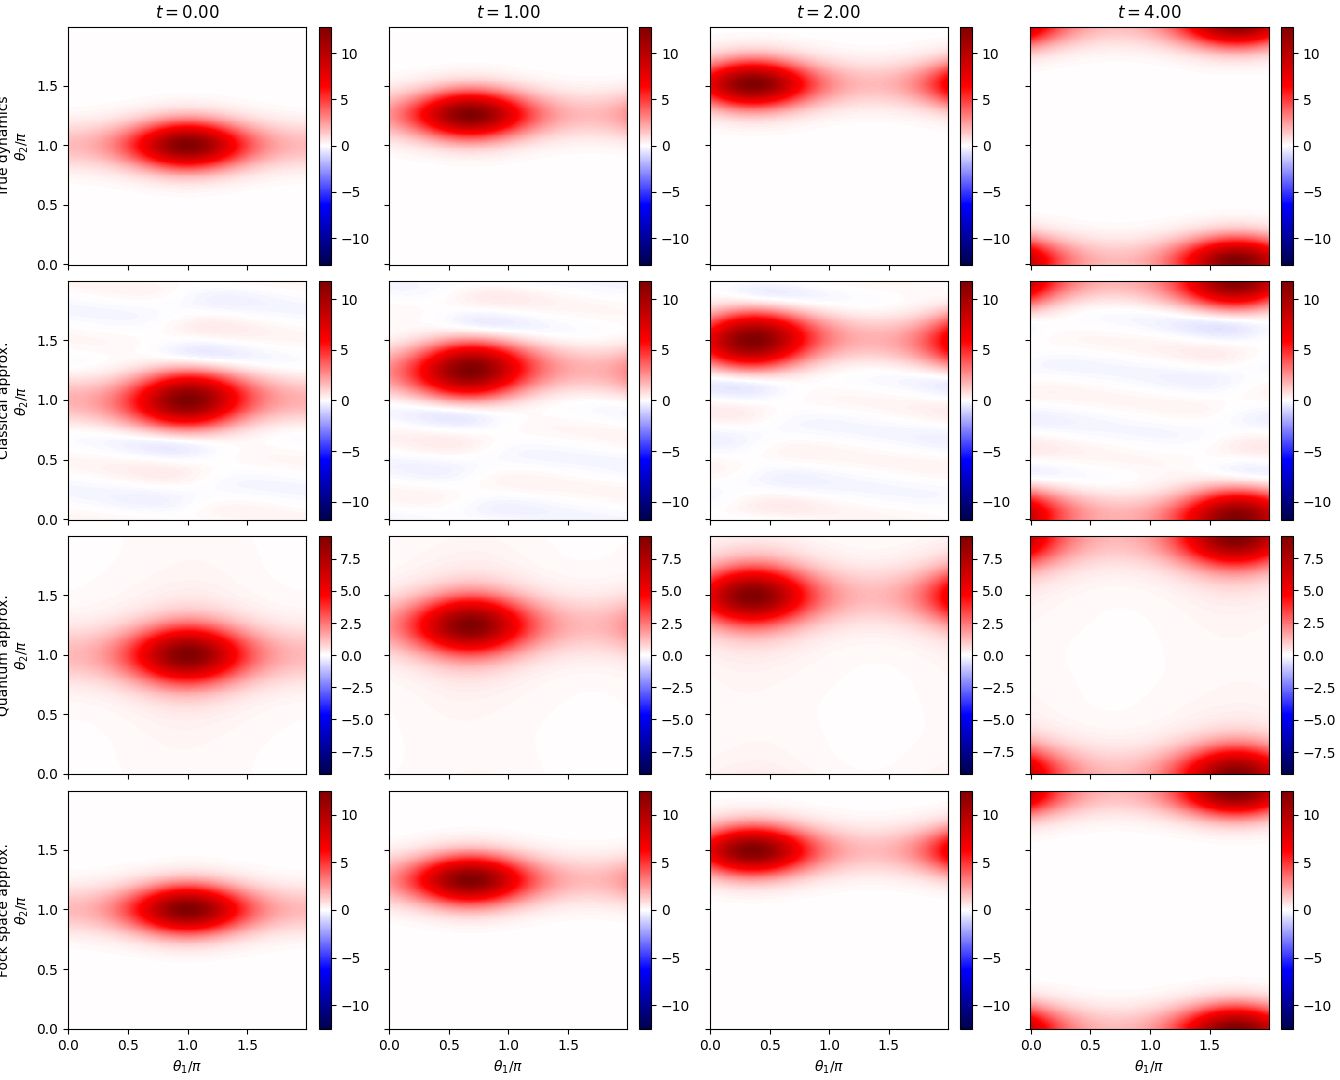

In [42]:
plt.figure(9)
plt.show()

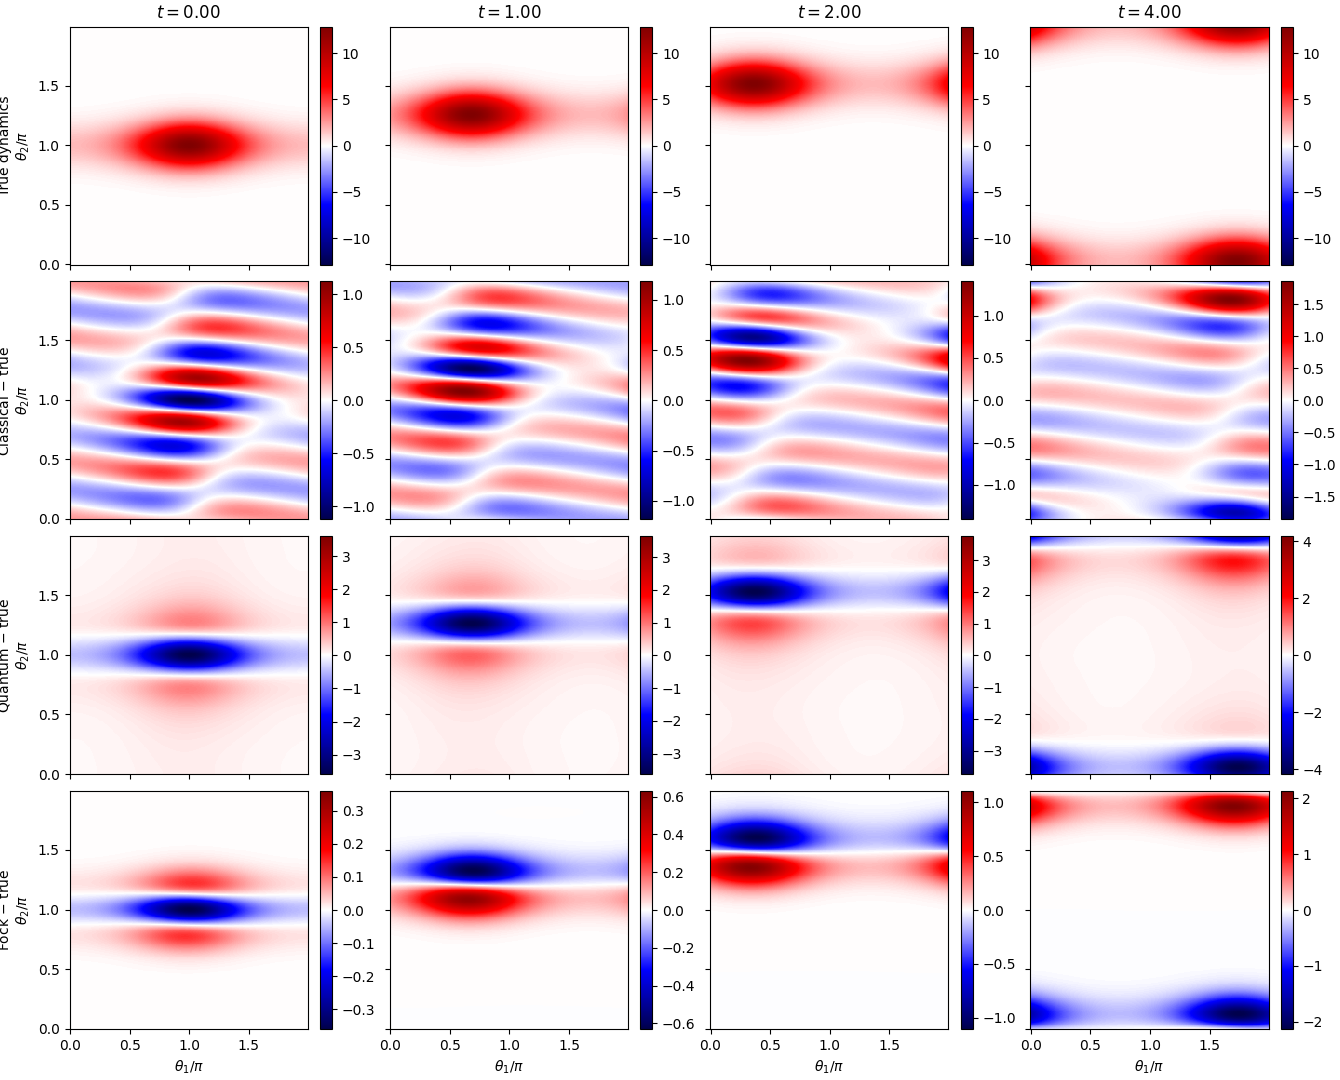

In [40]:
plt.figure(10)
plt.show()